# 1. Importing necessary Libraries

I will be using some of the visualization libraries like matplotlib, plotly for data exploration. I am planning to use Random Forest, Logistic Regression and XGBoost to find the model which gives higher accuracy for fraud detection.

In [1]:
#Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# 2. Importing Data and performing initial analysis


In [2]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [3]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [4]:
data.shape

(284807, 31)

We can observe that the data is very large and hence it is possible to get good accuracy by training some models like RF, LR, XGB.

Now let's check for the null values.

In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# 3. Data Visualization and Exploration

Let's check for the number of fraud vs not fraud transaction in the column Class by using Histogram.

In [6]:
#Checking Credit card fraud Class
px.histogram(data_frame = data, x='Class', color='Class')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



From the histogram we can observe that there are incredible amount of non-fraudulent transactions as compared to the fraudulent ones. i.e. There are 492 Fraudulent trasactions. 
So, the data is highly unbalanced.

In [7]:
fraud = data.loc[data['Class']==1]['Time']
not_fraud = data.loc[data['Class']==0]['Time']

histogram = [fraud, not_fraud]
group_labels = ['Fraud', 'Not Fraud']

fig = ff.create_distplot(histogram, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

From the graph we can observe that fraudulent transactions are more equally distributed in time in comparison with the non-fraudulent ones.

In [8]:
data['Hour'] = data['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

Hour  Class   Min      Max  Transactions        Sum        Mean   Median  \
0   0.0      0   0.0  7712.43          3961  256572.87   64.774772   12.990   
1   0.0      1   0.0   529.00             2     529.00  264.500000  264.500   
2   1.0      0   0.0  1769.69          2215  145806.76   65.826980   22.820   
3   1.0      1  59.0   239.93             2     298.93  149.465000  149.465   
4   2.0      0   0.0  4002.88          1555  106989.39   68.803466   17.900   

             Var  
0   45615.821201  
1  139920.500000  
2   20053.615770  
3   16367.832450  
4   45355.430437

# 4. Model Implementation

We will define our dependent and independent features by 'y' and 'X'. 


In [9]:
y = 'Class'
X = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Let's import all the necessary models and metrics from scikit-learn.

In [10]:
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

In [11]:
#Splitting the dataset into training and testing and also splitting the training data into training and validation.
train_df, test_df = train_test_split(data, test_size=0.2, random_state=5, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=5, shuffle=True )

## 1. Random Forest

In [12]:
RFC = RandomForestClassifier(random_state=5, 
                             n_jobs=4, 
                             criterion='gini', 
                             n_estimators=100, 
                             verbose=False)

In [13]:
RFC.fit(train_df[X], train_df[y].values)

RandomForestClassifier(n_jobs=4, random_state=5, verbose=False)

In [14]:
predictions = RFC.predict(valid_df[X])

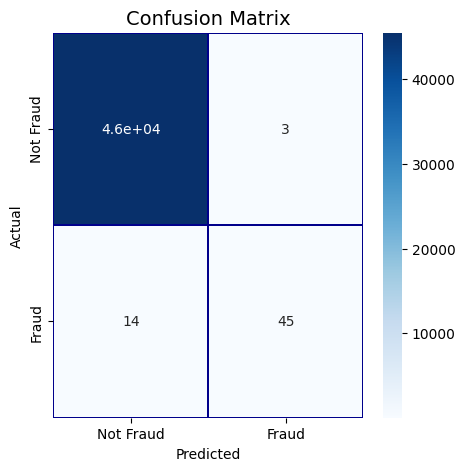

In [15]:
cm = pd.crosstab(valid_df[y].values, predictions, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [16]:
roc_auc_score(valid_df[y].values, predictions)

0.8813229724143324

The **ROC-AUC** score obtained from **Random Forest Classfier** is **0.88**.

## 2. Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()

In [18]:
LR.fit(train_df[X], train_df[y].values)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [19]:
lr_predictions = LR.predict(valid_df[X])

In [20]:
roc_auc_score(valid_df[y].values, lr_predictions)

0.8387633189204087

The **ROC-AUC** score obtained from **Logistic Regression** is **0.83**.

## 3. XGBoost

In [21]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[X], train_df[y].values)
dvalid = xgb.DMatrix(valid_df[X], valid_df[y].values)
dtest = xgb.DMatrix(test_df[X], test_df[y].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = 5

In [22]:
model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds=50, 
                maximize=True, 
                verbose_eval=50)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning:

Pass `evals` as keyword args.

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[12:40:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.92491	valid-auc:0.92316
[49]	train-auc:0.93040	valid-auc:0.92253


In [23]:
xgb_preds = model.predict(dtest)

In [24]:
roc_auc_score(test_df[y].values, xgb_preds)

0.9314560125494823

We have obtained the highest ROC-AUC score for XGBoost which is 0.93.

# Conclusion

Out of all three models which we have used for this particular dataset, we observe that XGBoost give the highest accuracy.